## Instal requirements

In [ ]:
!pip install transformers
!pip install fastBPE
!pip install fairseq
!pip install vncorenlp
!pip install scikit-learn

In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


In [ ]:
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz
!rm -rf PhoBERT_base_transformers.tar.gz

In [ ]:
!wget https://public.vinai.io/PhoBERT_large_transformers.tar.gz
!tar -xzvf PhoBERT_large_transformers.tar.gz
!rm -rf PhoBERT_large_transformers.tar.gz

In [ ]:
!wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
!tar -xzvf PhoBERT_base_fairseq.tar.gz
!rm -rf PhoBERT_base_fairseq.tar.gz

## Import dependencies

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [1]:
import pandas as pd
import re
import sqlite3
import string
import pickle

In [2]:
# data = pd.read_csv('/content/drive/MyDrive/DATN/DATA/DataV1/data_datn_trainV1_numberlable_6_1.csv')
# data.head(10)

In [2]:
conn_train = sqlite3.connect("../Data/raw/data_train_clean.db")
crs_train = conn_train.cursor()
data_train = pd.read_sql_query("SELECT * FROM data ORDER BY RANDOM()", conn_train)

conn_test = sqlite3.connect("../Data/raw/data_test_clean.db")
crs_test = conn_test.cursor()
data_test = pd.read_sql_query("SELECT * FROM data ORDER BY RANDOM()", conn_test)


In [3]:
train_data = pd.DataFrame()
train_data['title'] = data_train.Posts
train_data['label'] = data_train['Emotion']

test_data = pd.DataFrame()
test_data['title'] = data_test.Posts
test_data['label'] = data_test['Emotion']

In [4]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [5]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="./PhoBERT_base_transformers/bpe.codes",
    # default="./PhoBERT_large_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")
# vocab.add_from_file("./PhoBERT_large_transformers/dict.txt")

Loading codes from ./PhoBERT_base_transformers/bpe.codes ...
Read 64000 codes from the codes file.


In [7]:
def removeStopWord():
   f = open("../StopWords/vietnamese-stopwords-dash.txt", "r")
   stopWords = f.readlines()
   for idx,line  in enumerate(stopWords):
      stopWords[idx] = line.replace("\n", "").strip()
      if (len(stopWords[idx]) <= 0):
         stopWords.pop(idx)
   return stopWords

stopWords = removeStopWord()

In [8]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [9]:
with open('../Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(
        u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)


In [10]:
# puncs = string.punctuation + '“”’'
# puncs = string.punctuation.replace("_", "")

In [6]:
train_text = train_data['title'].to_list()
train_labels = train_data['label'].to_list()
# train_text = [re.sub(r'^\s+|\s+$', '', str(t)) for t in train_text]
# train_text = [str(t).strip() for t in train_text]
# train_text = [re.sub(r'\s\s+', ' ', str(t)) for t in train_text]
# train_text = [re.sub(r'\n', ' ', str(t)) for t in train_text]
# train_text = [re.sub(r'\d+', '', str(t)) for t in train_text]
# train_text = [re.sub(r'http\S+', '', str(t)) for t in train_text]
# train_text = [remove_emoji(str(t)) for t in train_text]
# train_text = [remove_emoticons(str(t)) for t in train_text]
# train_text = [str(t).translate(str.maketrans('', '', puncs)) for t in train_text]
# train_text = [str(t).replace("_", " ") for t in train_text]
# train_text = [str(t).strip() for t in train_text]
# train_text = [str(t).lower() for t in train_text]
# train_text = [rdrsegmenter.tokenize(t) for t in train_text]
# for idx, text in enumerate(train_text):
#     for idx2, text2 in enumerate(text):
#         for idx3, text3 in enumerate(text2):
#             if text3 in stopWords:
#                 text2.pop(idx3)
#         if len(text2) <= 0:
#             text.pop(idx2)
#     if len(text) <= 0:
#         train_text.pop(idx)
#         train_labels.pop(idx)
# for idx, text in enumerate(train_text):
#     tmp = []
#     for idx2, text2 in enumerate(text):
#         tmp2 = []
#         for idx3, text3 in enumerate(text2):
#             # if not text3.startswith("'") and text3 not in string.punctuation:
#             #    tmp2.append(" "+text3)
#             # else:
#             #    tmp2.append(text3)
#             if text3 not in puncs:
#                 tmp2.append(" "+text3)
#         tmp.append("".join(tmp2).strip())
#     train_text[idx] = " ".join(tmp).strip()
# train_text = [re.sub(r'\s+_\s+', '_', str(t)) for t in train_text]

test_text = test_data['title'].to_list()
test_labels = test_data['label'].to_list()
# test_text = [re.sub(r'^\s+|\s+$', '', str(t)) for t in test_text]
# test_text = [str(t).strip() for t in test_text]
# test_text = [re.sub(r'\s\s+', ' ', str(t)) for t in test_text]
# test_text = [re.sub(r'\n', ' ', str(t)) for t in test_text]
# test_text = [re.sub(r'\d+', '', str(t)) for t in test_text]
# test_text = [re.sub(r'http\S+', '', str(t)) for t in test_text]
# test_text = [remove_emoji(str(t)) for t in test_text]
# test_text = [remove_emoticons(str(t)) for t in test_text]
# test_text = [str(t).translate(str.maketrans('', '', puncs)) for t in test_text]
# test_text = [str(t).replace("_", " ") for t in test_text]
# test_text = [str(t).strip() for t in test_text]
# test_text = [str(t).lower() for t in test_text]
# test_text = [rdrsegmenter.tokenize(t) for t in test_text]
# for idx, text in enumerate(test_text):
#     for idx2, text2 in enumerate(text):
#         for idx3, text3 in enumerate(text2):
#             if text3 in stopWords:
#                 text2.pop(idx3)
#         if len(text2) <= 0:
#             text.pop(idx2)
#     if len(text) <= 0:
#         test_text.pop(idx)
#         test_labels.pop(idx)
# for idx, text in enumerate(test_text):
#     tmp = []
#     for idx2, text2 in enumerate(text):
#         tmp2 = []
#         for idx3, text3 in enumerate(text2):
#             # if not text3.startswith("'") and text3 not in string.punctuation:
#             #    tmp2.append(" "+text3)
#             # else:
#             #    tmp2.append(text3)
#             if text3 not in puncs:
#                 tmp2.append(" "+text3)
#         tmp.append("".join(tmp2).strip())
#     test_text[idx] = " ".join(tmp).strip()
# test_text = [re.sub(r'\s+_\s+', '_', str(t)) for t in test_text]


In [12]:
# train_path = './train.txt'
# test_path = './test.txt'

# train_id, train_text, train_labels = [], [], []
# test_id, test_text, test_labels = [], [], []

# with open(train_path, 'r') as f_r:
#     data1 = f_r.read().strip()

#     data = re.findall('train_[\s\S]+?\n.*\n[0-8]\n\n', data1)

#     for sample in data:
#         splits = sample.strip().split('\n')
#         # print(splits)
#         id = splits[0]
#         label = int(splits[-1])
#         # print(label)
#         text = ' '.join(splits[1:-1])
#         text = rdrsegmenter.tokenize(text)
#         text = ' '.join([' '.join(x) for x in text])

#         train_id.append(id)
#         train_text.append(text)
#         train_labels.append(label)


# with open(test_path, 'r') as f_r:
#     data1 = f_r.read().strip()
#     data = re.findall('test_[\s\S]+?\n.*\n[0-8]\n\n', data1)

#     for sample in data:
#         splits = sample.strip().split('\n')

#         id = splits[0]
#         label = int(splits[-1])
#         text = ' '.join(splits[1:-1])
#         text = rdrsegmenter.tokenize(text)
#         text = ' '.join([' '.join(x) for x in text])

#         test_id.append(id)
#         test_text.append(text)
#         test_labels.append(label)

# for i in range(len(train_labels)):
#   train_labels[i] = train_labels[i] 

# for i in range(len(test_labels)):
#   test_labels[i] = test_labels[i]
# print(train_labels)

In [13]:
# from sklearn.model_selection import train_test_split

# train_sents, val_sents, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.1)
# print(len(train_labels))
# print(len(val_labels))

In [8]:
train_sents = train_text
train_labels = train_labels
val_sents = test_text
val_labels = test_labels

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 30

train_ids = []
for sent in train_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encoded_sent)

val_ids = []
for sent in val_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    val_ids.append(encoded_sent)
    
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
# print(train_ids)
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
# print(val_ids)

In [10]:
train_masks = []
for sent in train_ids:
    mask = [int(token_id > 0) for token_id in sent]
    train_masks.append(mask)

val_masks = []
for sent in val_ids:
    mask = [int(token_id > 0) for token_id in sent]

    val_masks.append(mask)


In [11]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
import torch
# device = torch.device("mps" if torch.has_mps else "cpu")
device = "cpu"
train_inputs = torch.tensor(train_ids, device=device)
val_inputs = torch.tensor(val_ids, device=device)
# print(train_labels)
train_labels = torch.tensor(train_labels, device=device)
val_labels = torch.tensor(val_labels, device=device)
train_masks = torch.tensor(train_masks, device=device)
val_masks = torch.tensor(val_masks, device=device)

# print(train_labels)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
# print(train_data)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=64)
# print(train_dataloader)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(
    val_data, sampler=val_sampler, batch_size=64)


In [12]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

config = RobertaConfig.from_pretrained(
    "./configs/base/config.json"
    # "./PhoBERT_large_transformers/config.json"
    , from_tf=False, num_labels = 6, output_hidden_states=False
)
BERT_SA = RobertaForSequenceClassification.from_pretrained(
    "./PhoBERT_base_transformers/model.bin",
    # "./PhoBERT_large_transformers/model.bin",
    config = config
)

Some weights of the model checkpoint at ./PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['roberta.encoder.layer.5.attention.self.query.weight', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.4.output.LayerNorm.weight', 'roberta.encoder.layer.5.output.dense.weight', 'roberta.encoder.layer.6.attention.self.value.weight', 'lm_head.dense.bias', 'roberta.encoder.layer.5.attention.self.value.bias', 'roberta.pooler.dense.weight', 'roberta.encoder.layer.9.intermediate.dense.weight', 'lm_head.layer_norm.weight', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.8.output.LayerNorm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.7.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.self.query.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.9.intermediate.de

In [19]:
# BERT_SA.cuda()
# print('Done')
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())


True
True


In [13]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

In [14]:
print(len(train_dataloader))
print(len(val_dataloader))

104
9


In [15]:
import random
import time
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

# device = torch.device("mps" if torch.has_mps else "cpu")
device = "cpu"
epochs = 500
max = 0

param_optimizer = list(BERT_SA.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

echo = []
acc = []
acc_val = []
av_loss = []
f1 = []
f1_val = []
start_time = time.time()
e = 0
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    echo.append(epoch_i)

    total_loss = 0
    BERT_SA.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # print(b_labels)
        BERT_SA.zero_grad()
        outputs = BERT_SA(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels)
        loss = outputs[0]
        # print(outputs)
        total_loss += loss.item()

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1

        loss.backward()
        torch.nn.utils.clip_grad_norm_(BERT_SA.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    acc.append(float("{:.4f}".format(train_accuracy/nb_train_steps)))

    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    f1.append(float("{:.4f}".format(train_f1/nb_train_steps)))

    print(" Average training loss: {0:.4f}".format(avg_train_loss))
    av_loss.append(float("{:.4f}".format(avg_train_loss)))

    BERT_SA.save_pretrained('./model/{}'.format(epoch_i+1))
    print("Running Validation...")
    BERT_SA.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    for batch in tqdm(val_dataloader, total=len(val_dataloader)):

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        # print(b_labels)

        with torch.no_grad():
            outputs = BERT_SA(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask)
            logits = outputs[0]
            # loss_val=outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # print(logits)
            # print(label_ids)

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    if max < eval_accuracy/nb_eval_steps:
        max = eval_accuracy/nb_eval_steps
        e = epoch_i
    print('logits:    {}'.format(np.argmax(logits, axis=1).flatten()))
    print('labels_id: {}'.format(label_ids))

    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    acc_val.append(float("{:.4f}".format(eval_accuracy/nb_eval_steps)))

    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
    f1_val.append(float("{:.4f}".format(eval_f1/nb_eval_steps)))
print("Training complete!")
print('Best Valid acc : {}, epoch: {}'.format(max, e+1))
end_time = time.time()
elapsed_time = end_time - start_time
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")


======== Epoch 1 / 500 ========
Training...


/Users/maddie/Desktop/DATN/HoangPhiLong/Code/env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2489
 F1 score: 0.1291
 Average training loss: 1.7466
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.1958
 F1 score: 0.0962
======== Epoch 2 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2781
 F1 score: 0.1460
 Average training loss: 1.6989
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 1 5]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2010
 F1 score: 0.0999
======== Epoch 3 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2964
 F1 score: 0.1606
 Average training loss: 1.6734
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 1 5]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2045
 F1 score: 0.1031
======== Epoch 4 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2810
 F1 score: 0.1514
 Average training loss: 1.6615
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 1 5]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2079
 F1 score: 0.1125
======== Epoch 5 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2867
 F1 score: 0.1559
 Average training loss: 1.6509
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2054
 F1 score: 0.1073
======== Epoch 6 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2915
 F1 score: 0.1593
 Average training loss: 1.6432
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2097
 F1 score: 0.1132
======== Epoch 7 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2975
 F1 score: 0.1633
 Average training loss: 1.6353
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2062
 F1 score: 0.1101
======== Epoch 8 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2968
 F1 score: 0.1636
 Average training loss: 1.6315
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2062
 F1 score: 0.1106
======== Epoch 9 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2958
 F1 score: 0.1628
 Average training loss: 1.6280
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2097
 F1 score: 0.1133
======== Epoch 10 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3013
 F1 score: 0.1644
 Average training loss: 1.6222
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2131
 F1 score: 0.1172
======== Epoch 11 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2933
 F1 score: 0.1600
 Average training loss: 1.6197
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2131
 F1 score: 0.1169
======== Epoch 12 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3073
 F1 score: 0.1706
 Average training loss: 1.6178
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2114
 F1 score: 0.1164
======== Epoch 13 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3064
 F1 score: 0.1677
 Average training loss: 1.6121
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2097
 F1 score: 0.1148
======== Epoch 14 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2966
 F1 score: 0.1640
 Average training loss: 1.6125
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2062
 F1 score: 0.1118
======== Epoch 15 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3110
 F1 score: 0.1716
 Average training loss: 1.6063
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2114
 F1 score: 0.1176
======== Epoch 16 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.2967
 F1 score: 0.1634
 Average training loss: 1.6049
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2131
 F1 score: 0.1205
======== Epoch 17 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3038
 F1 score: 0.1706
 Average training loss: 1.6031
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2218
 F1 score: 0.1316
======== Epoch 18 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3136
 F1 score: 0.1791
 Average training loss: 1.5997
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2218
 F1 score: 0.1335
======== Epoch 19 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3085
 F1 score: 0.1735
 Average training loss: 1.5960
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2201
 F1 score: 0.1386
======== Epoch 20 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3124
 F1 score: 0.1793
 Average training loss: 1.5958
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2278
 F1 score: 0.1508
======== Epoch 21 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3162
 F1 score: 0.1829
 Average training loss: 1.5927
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2382
 F1 score: 0.1630
======== Epoch 22 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3084
 F1 score: 0.1772
 Average training loss: 1.5910
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2417
 F1 score: 0.1639
======== Epoch 23 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3237
 F1 score: 0.1896
 Average training loss: 1.5828
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2417
 F1 score: 0.1648
======== Epoch 24 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3245
 F1 score: 0.1939
 Average training loss: 1.5805
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2487
 F1 score: 0.1707
======== Epoch 25 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3172
 F1 score: 0.1922
 Average training loss: 1.5790
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2469
 F1 score: 0.1705
======== Epoch 26 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3311
 F1 score: 0.2037
 Average training loss: 1.5757
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2469
 F1 score: 0.1699
======== Epoch 27 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3218
 F1 score: 0.2027
 Average training loss: 1.5724
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2504
 F1 score: 0.1730
======== Epoch 28 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3288
 F1 score: 0.2066
 Average training loss: 1.5720
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2521
 F1 score: 0.1734
======== Epoch 29 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3363
 F1 score: 0.2166
 Average training loss: 1.5664
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2556
 F1 score: 0.1753
======== Epoch 30 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3370
 F1 score: 0.2189
 Average training loss: 1.5624
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2573
 F1 score: 0.1790
======== Epoch 31 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3377
 F1 score: 0.2205
 Average training loss: 1.5581
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2573
 F1 score: 0.1810
======== Epoch 32 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3431
 F1 score: 0.2244
 Average training loss: 1.5505
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2608
 F1 score: 0.1840
======== Epoch 33 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3483
 F1 score: 0.2299
 Average training loss: 1.5516
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 5 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2678
 F1 score: 0.1896
======== Epoch 34 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3447
 F1 score: 0.2287
 Average training loss: 1.5464
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 5 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2730
 F1 score: 0.1938
======== Epoch 35 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3483
 F1 score: 0.2299
 Average training loss: 1.5436
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 5 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2678
 F1 score: 0.1892
======== Epoch 36 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3590
 F1 score: 0.2421
 Average training loss: 1.5419
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 5 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2712
 F1 score: 0.1929
======== Epoch 37 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3507
 F1 score: 0.2338
 Average training loss: 1.5365
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2738
 F1 score: 0.1948
======== Epoch 38 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3558
 F1 score: 0.2397
 Average training loss: 1.5339
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2703
 F1 score: 0.1927
======== Epoch 39 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3599
 F1 score: 0.2417
 Average training loss: 1.5305
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2738
 F1 score: 0.1953
======== Epoch 40 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3551
 F1 score: 0.2399
 Average training loss: 1.5302
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2755
 F1 score: 0.1967
======== Epoch 41 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3592
 F1 score: 0.2430
 Average training loss: 1.5234
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2772
 F1 score: 0.1967
======== Epoch 42 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3658
 F1 score: 0.2483
 Average training loss: 1.5161
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2772
 F1 score: 0.1967
======== Epoch 43 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3679
 F1 score: 0.2499
 Average training loss: 1.5138
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2790
 F1 score: 0.1982
======== Epoch 44 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3710
 F1 score: 0.2525
 Average training loss: 1.5093
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2807
 F1 score: 0.2001
======== Epoch 45 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3713
 F1 score: 0.2557
 Average training loss: 1.5084
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 2 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2799
 F1 score: 0.1997
======== Epoch 46 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3731
 F1 score: 0.2541
 Average training loss: 1.5021
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2859
 F1 score: 0.2026
======== Epoch 47 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3735
 F1 score: 0.2549
 Average training loss: 1.4996
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2911
 F1 score: 0.2073
======== Epoch 48 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3804
 F1 score: 0.2610
 Average training loss: 1.4961
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 2 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2938
 F1 score: 0.2110
======== Epoch 49 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3770
 F1 score: 0.2571
 Average training loss: 1.4952
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 2 0 0 5 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2921
 F1 score: 0.2091
======== Epoch 50 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3773
 F1 score: 0.2592
 Average training loss: 1.4909
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2963
 F1 score: 0.2134
======== Epoch 51 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3833
 F1 score: 0.2618
 Average training loss: 1.4858
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2963
 F1 score: 0.2130
======== Epoch 52 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3875
 F1 score: 0.2656
 Average training loss: 1.4893
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.2981
 F1 score: 0.2136
======== Epoch 53 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3920
 F1 score: 0.2691
 Average training loss: 1.4775
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3033
 F1 score: 0.2181
======== Epoch 54 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3979
 F1 score: 0.2736
 Average training loss: 1.4745
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 1 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3033
 F1 score: 0.2179
======== Epoch 55 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3897
 F1 score: 0.2668
 Average training loss: 1.4687
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3068
 F1 score: 0.2209
======== Epoch 56 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4013
 F1 score: 0.2746
 Average training loss: 1.4668
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3068
 F1 score: 0.2214
======== Epoch 57 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4020
 F1 score: 0.2768
 Average training loss: 1.4615
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3102
 F1 score: 0.2261
======== Epoch 58 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.3928
 F1 score: 0.2702
 Average training loss: 1.4612
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3102
 F1 score: 0.2266
======== Epoch 59 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4002
 F1 score: 0.2762
 Average training loss: 1.4594
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3120
 F1 score: 0.2314
======== Epoch 60 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4105
 F1 score: 0.2842
 Average training loss: 1.4566
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3137
 F1 score: 0.2328
======== Epoch 61 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4092
 F1 score: 0.2816
 Average training loss: 1.4517
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3154
 F1 score: 0.2335
======== Epoch 62 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4102
 F1 score: 0.2832
 Average training loss: 1.4488
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3154
 F1 score: 0.2334
======== Epoch 63 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4112
 F1 score: 0.2830
 Average training loss: 1.4472
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3172
 F1 score: 0.2341
======== Epoch 64 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4132
 F1 score: 0.2852
 Average training loss: 1.4456
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3172
 F1 score: 0.2340
======== Epoch 65 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4167
 F1 score: 0.2879
 Average training loss: 1.4406
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 5 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3206
 F1 score: 0.2364
======== Epoch 66 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4206
 F1 score: 0.2905
 Average training loss: 1.4407
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3259
 F1 score: 0.2391
======== Epoch 67 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4198
 F1 score: 0.2897
 Average training loss: 1.4350
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3259
 F1 score: 0.2390
======== Epoch 68 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4242
 F1 score: 0.2913
 Average training loss: 1.4298
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3311
 F1 score: 0.2445
======== Epoch 69 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4212
 F1 score: 0.2900
 Average training loss: 1.4280
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 1 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3328
 F1 score: 0.2452
======== Epoch 70 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4293
 F1 score: 0.2968
 Average training loss: 1.4206
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3363
 F1 score: 0.2485
======== Epoch 71 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4336
 F1 score: 0.2997
 Average training loss: 1.4169
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3380
 F1 score: 0.2498
======== Epoch 72 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4356
 F1 score: 0.3004
 Average training loss: 1.4175
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3380
 F1 score: 0.2498
======== Epoch 73 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4361
 F1 score: 0.3015
 Average training loss: 1.4126
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 1 1 0 0 1 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3380
 F1 score: 0.2496
======== Epoch 74 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4335
 F1 score: 0.2994
 Average training loss: 1.4091
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 1 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3397
 F1 score: 0.2523
======== Epoch 75 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4314
 F1 score: 0.2989
 Average training loss: 1.4088
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3458
 F1 score: 0.2572
======== Epoch 76 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4389
 F1 score: 0.3032
 Average training loss: 1.4046
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2554
======== Epoch 77 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4335
 F1 score: 0.3001
 Average training loss: 1.4028
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2554
======== Epoch 78 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4378
 F1 score: 0.3027
 Average training loss: 1.4006
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3405
 F1 score: 0.2517
======== Epoch 79 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4395
 F1 score: 0.3035
 Average training loss: 1.3952
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3388
 F1 score: 0.2512
======== Epoch 80 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4353
 F1 score: 0.3018
 Average training loss: 1.3995
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3371
 F1 score: 0.2505
======== Epoch 81 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4475
 F1 score: 0.3097
 Average training loss: 1.3864
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3353
 F1 score: 0.2491
======== Epoch 82 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4446
 F1 score: 0.3084
 Average training loss: 1.3809
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3423
 F1 score: 0.2538
======== Epoch 83 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4421
 F1 score: 0.3049
 Average training loss: 1.3861
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2546
======== Epoch 84 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4503
 F1 score: 0.3120
 Average training loss: 1.3813
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2546
======== Epoch 85 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4526
 F1 score: 0.3137
 Average training loss: 1.3817
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2555
======== Epoch 86 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4532
 F1 score: 0.3147
 Average training loss: 1.3804
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2555
======== Epoch 87 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4513
 F1 score: 0.3126
 Average training loss: 1.3695
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2561
======== Epoch 88 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4472
 F1 score: 0.3115
 Average training loss: 1.3713
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3423
 F1 score: 0.2549
======== Epoch 89 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4636
 F1 score: 0.3199
 Average training loss: 1.3587
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2571
======== Epoch 90 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4479
 F1 score: 0.3107
 Average training loss: 1.3664
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3492
 F1 score: 0.2604
======== Epoch 91 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4538
 F1 score: 0.3150
 Average training loss: 1.3663
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3475
 F1 score: 0.2584
======== Epoch 92 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4620
 F1 score: 0.3209
 Average training loss: 1.3561
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3458
 F1 score: 0.2589
======== Epoch 93 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4597
 F1 score: 0.3189
 Average training loss: 1.3534
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2564
======== Epoch 94 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4563
 F1 score: 0.3172
 Average training loss: 1.3560
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3458
 F1 score: 0.2574
======== Epoch 95 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4558
 F1 score: 0.3154
 Average training loss: 1.3587
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3492
 F1 score: 0.2610
======== Epoch 96 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4664
 F1 score: 0.3247
 Average training loss: 1.3500
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3475
 F1 score: 0.2593
======== Epoch 97 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4656
 F1 score: 0.3250
 Average training loss: 1.3497
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3492
 F1 score: 0.2609
======== Epoch 98 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4670
 F1 score: 0.3237
 Average training loss: 1.3486
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3492
 F1 score: 0.2618
======== Epoch 99 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4639
 F1 score: 0.3216
 Average training loss: 1.3430
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3527
 F1 score: 0.2642
======== Epoch 100 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4623
 F1 score: 0.3226
 Average training loss: 1.3425
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3475
 F1 score: 0.2606
======== Epoch 101 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4692
 F1 score: 0.3287
 Average training loss: 1.3379
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3475
 F1 score: 0.2601
======== Epoch 102 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4695
 F1 score: 0.3271
 Average training loss: 1.3386
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3458
 F1 score: 0.2595
======== Epoch 103 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4721
 F1 score: 0.3297
 Average training loss: 1.3329
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3458
 F1 score: 0.2596
======== Epoch 104 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4742
 F1 score: 0.3297
 Average training loss: 1.3326
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2570
======== Epoch 105 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4766
 F1 score: 0.3321
 Average training loss: 1.3280
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2581
======== Epoch 106 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4777
 F1 score: 0.3343
 Average training loss: 1.3281
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3440
 F1 score: 0.2572
======== Epoch 107 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4743
 F1 score: 0.3313
 Average training loss: 1.3223
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3423
 F1 score: 0.2558
======== Epoch 108 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4780
 F1 score: 0.3346
 Average training loss: 1.3215
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3492
 F1 score: 0.2635
======== Epoch 109 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4842
 F1 score: 0.3419
 Average training loss: 1.3160
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3527
 F1 score: 0.2662
======== Epoch 110 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4767
 F1 score: 0.3342
 Average training loss: 1.3160
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3527
 F1 score: 0.2670
======== Epoch 111 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4845
 F1 score: 0.3414
 Average training loss: 1.3060
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3492
 F1 score: 0.2636
======== Epoch 112 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4839
 F1 score: 0.3404
 Average training loss: 1.3077
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3510
 F1 score: 0.2654
======== Epoch 113 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4811
 F1 score: 0.3395
 Average training loss: 1.3069
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3527
 F1 score: 0.2679
======== Epoch 114 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4850
 F1 score: 0.3423
 Average training loss: 1.3010
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3544
 F1 score: 0.2715
======== Epoch 115 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4834
 F1 score: 0.3383
 Average training loss: 1.3049
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3458
 F1 score: 0.2637
======== Epoch 116 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4842
 F1 score: 0.3401
 Average training loss: 1.3030
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3527
 F1 score: 0.2713
======== Epoch 117 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4856
 F1 score: 0.3443
 Average training loss: 1.2968
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3510
 F1 score: 0.2701
======== Epoch 118 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4904
 F1 score: 0.3485
 Average training loss: 1.2949
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 1 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3544
 F1 score: 0.2749
======== Epoch 119 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4882
 F1 score: 0.3448
 Average training loss: 1.2950
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 0 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3622
 F1 score: 0.2803
======== Epoch 120 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4860
 F1 score: 0.3467
 Average training loss: 1.2943
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3682
 F1 score: 0.2880
======== Epoch 121 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4880
 F1 score: 0.3476
 Average training loss: 1.2945
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3665
 F1 score: 0.2866
======== Epoch 122 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4927
 F1 score: 0.3504
 Average training loss: 1.2880
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3665
 F1 score: 0.2874
======== Epoch 123 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4844
 F1 score: 0.3434
 Average training loss: 1.2961
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3699
 F1 score: 0.2922
======== Epoch 124 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4892
 F1 score: 0.3466
 Average training loss: 1.2837
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3734
 F1 score: 0.2995
======== Epoch 125 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4980
 F1 score: 0.3547
 Average training loss: 1.2846
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3734
 F1 score: 0.2993
======== Epoch 126 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4983
 F1 score: 0.3524
 Average training loss: 1.2742
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3734
 F1 score: 0.2995
======== Epoch 127 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5001
 F1 score: 0.3583
 Average training loss: 1.2819
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3734
 F1 score: 0.2997
======== Epoch 128 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4892
 F1 score: 0.3453
 Average training loss: 1.2775
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3734
 F1 score: 0.2994
======== Epoch 129 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4962
 F1 score: 0.3550
 Average training loss: 1.2763
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 2 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3786
 F1 score: 0.3042
======== Epoch 130 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4932
 F1 score: 0.3497
 Average training loss: 1.2763
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3751
 F1 score: 0.3020
======== Epoch 131 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.4968
 F1 score: 0.3562
 Average training loss: 1.2673
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3786
 F1 score: 0.3067
======== Epoch 132 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5029
 F1 score: 0.3621
 Average training loss: 1.2684
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3821
 F1 score: 0.3103
======== Epoch 133 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5010
 F1 score: 0.3577
 Average training loss: 1.2690
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3856
 F1 score: 0.3148
======== Epoch 134 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5083
 F1 score: 0.3663
 Average training loss: 1.2615
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 4 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3856
 F1 score: 0.3148
======== Epoch 135 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5038
 F1 score: 0.3632
 Average training loss: 1.2673
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [1 0 2 0 1 1 0 0 2 3 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3881
 F1 score: 0.3201
======== Epoch 136 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5102
 F1 score: 0.3715
 Average training loss: 1.2543
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3821
 F1 score: 0.3168
======== Epoch 137 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5122
 F1 score: 0.3759
 Average training loss: 1.2570
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 0 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3838
 F1 score: 0.3187
======== Epoch 138 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5105
 F1 score: 0.3699
 Average training loss: 1.2545
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3898
 F1 score: 0.3249
======== Epoch 139 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5097
 F1 score: 0.3735
 Average training loss: 1.2558
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3881
 F1 score: 0.3232
======== Epoch 140 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5142
 F1 score: 0.3772
 Average training loss: 1.2594
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3881
 F1 score: 0.3233
======== Epoch 141 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5132
 F1 score: 0.3780
 Average training loss: 1.2490
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3898
 F1 score: 0.3254
======== Epoch 142 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5184
 F1 score: 0.3810
 Average training loss: 1.2426
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3933
 F1 score: 0.3299
======== Epoch 143 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5115
 F1 score: 0.3706
 Average training loss: 1.2459
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3933
 F1 score: 0.3301
======== Epoch 144 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5211
 F1 score: 0.3806
 Average training loss: 1.2425
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3933
 F1 score: 0.3286
======== Epoch 145 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5212
 F1 score: 0.3790
 Average training loss: 1.2455
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3916
 F1 score: 0.3274
======== Epoch 146 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5183
 F1 score: 0.3823
 Average training loss: 1.2455
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.3916
 F1 score: 0.3277
======== Epoch 147 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5197
 F1 score: 0.3792
 Average training loss: 1.2302
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4002
 F1 score: 0.3411
======== Epoch 148 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5187
 F1 score: 0.3811
 Average training loss: 1.2357
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4002
 F1 score: 0.3412
======== Epoch 149 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5234
 F1 score: 0.3884
 Average training loss: 1.2326
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4020
 F1 score: 0.3421
======== Epoch 150 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5232
 F1 score: 0.3835
 Average training loss: 1.2262
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4020
 F1 score: 0.3421
======== Epoch 151 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5219
 F1 score: 0.3859
 Average training loss: 1.2247
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4037
 F1 score: 0.3433
======== Epoch 152 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5247
 F1 score: 0.3885
 Average training loss: 1.2303
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4054
 F1 score: 0.3473
======== Epoch 153 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5263
 F1 score: 0.3868
 Average training loss: 1.2225
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4072
 F1 score: 0.3538
======== Epoch 154 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5288
 F1 score: 0.3991
 Average training loss: 1.2178
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4072
 F1 score: 0.3538
======== Epoch 155 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5346
 F1 score: 0.3960
 Average training loss: 1.2118
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4072
 F1 score: 0.3538
======== Epoch 156 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5324
 F1 score: 0.3999
 Average training loss: 1.2162
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4072
 F1 score: 0.3537
======== Epoch 157 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5345
 F1 score: 0.4037
 Average training loss: 1.2111
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4072
 F1 score: 0.3556
======== Epoch 158 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5318
 F1 score: 0.3937
 Average training loss: 1.2087
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4072
 F1 score: 0.3556
======== Epoch 159 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5361
 F1 score: 0.4003
 Average training loss: 1.2049
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4072
 F1 score: 0.3556
======== Epoch 160 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5270
 F1 score: 0.3972
 Average training loss: 1.2079
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4107
 F1 score: 0.3590
======== Epoch 161 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5383
 F1 score: 0.4059
 Average training loss: 1.2044
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4107
 F1 score: 0.3594
======== Epoch 162 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5403
 F1 score: 0.4105
 Average training loss: 1.2001
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4107
 F1 score: 0.3599
======== Epoch 163 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5360
 F1 score: 0.4055
 Average training loss: 1.1980
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4107
 F1 score: 0.3600
======== Epoch 164 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5321
 F1 score: 0.4028
 Average training loss: 1.2037
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4064
 F1 score: 0.3549
======== Epoch 165 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5380
 F1 score: 0.4133
 Average training loss: 1.1907
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 4 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4107
 F1 score: 0.3601
======== Epoch 166 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5354
 F1 score: 0.4045
 Average training loss: 1.2005
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4124
 F1 score: 0.3633
======== Epoch 167 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5387
 F1 score: 0.4084
 Average training loss: 1.1969
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 0 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4081
 F1 score: 0.3590
======== Epoch 168 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5375
 F1 score: 0.4037
 Average training loss: 1.1919
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4124
 F1 score: 0.3636
======== Epoch 169 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5396
 F1 score: 0.4103
 Average training loss: 1.1932
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4159
 F1 score: 0.3673
======== Epoch 170 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5455
 F1 score: 0.4127
 Average training loss: 1.1912
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4176
 F1 score: 0.3731
======== Epoch 171 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5401
 F1 score: 0.4149
 Average training loss: 1.1883
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4211
 F1 score: 0.3764
======== Epoch 172 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5461
 F1 score: 0.4160
 Average training loss: 1.1822
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4228
 F1 score: 0.3780
======== Epoch 173 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5434
 F1 score: 0.4174
 Average training loss: 1.1874
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4245
 F1 score: 0.3837
======== Epoch 174 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5419
 F1 score: 0.4163
 Average training loss: 1.1868
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4280
 F1 score: 0.3862
======== Epoch 175 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5492
 F1 score: 0.4249
 Average training loss: 1.1749
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4298
 F1 score: 0.3921
======== Epoch 176 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5439
 F1 score: 0.4190
 Average training loss: 1.1788
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4332
 F1 score: 0.3957
======== Epoch 177 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5517
 F1 score: 0.4267
 Average training loss: 1.1765
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 4 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4332
 F1 score: 0.3959
======== Epoch 178 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5475
 F1 score: 0.4245
 Average training loss: 1.1685
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4375
 F1 score: 0.4018
======== Epoch 179 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5516
 F1 score: 0.4314
 Average training loss: 1.1671
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4323
 F1 score: 0.3965
======== Epoch 180 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5505
 F1 score: 0.4263
 Average training loss: 1.1703
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4375
 F1 score: 0.4019
======== Epoch 181 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5516
 F1 score: 0.4299
 Average training loss: 1.1703
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4410
 F1 score: 0.4057
======== Epoch 182 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5548
 F1 score: 0.4259
 Average training loss: 1.1652
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4392
 F1 score: 0.4037
======== Epoch 183 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5518
 F1 score: 0.4234
 Average training loss: 1.1646
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4392
 F1 score: 0.4039
======== Epoch 184 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5557
 F1 score: 0.4288
 Average training loss: 1.1711
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4358
 F1 score: 0.4013
======== Epoch 185 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5644
 F1 score: 0.4381
 Average training loss: 1.1516
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4375
 F1 score: 0.4031
======== Epoch 186 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5528
 F1 score: 0.4381
 Average training loss: 1.1596
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4392
 F1 score: 0.4042
======== Epoch 187 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5585
 F1 score: 0.4380
 Average training loss: 1.1583
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4358
 F1 score: 0.4019
======== Epoch 188 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5487
 F1 score: 0.4269
 Average training loss: 1.1627
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4444
 F1 score: 0.4095
======== Epoch 189 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5635
 F1 score: 0.4428
 Average training loss: 1.1510
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4136
======== Epoch 190 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5677
 F1 score: 0.4404
 Average training loss: 1.1517
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4133
======== Epoch 191 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5659
 F1 score: 0.4469
 Average training loss: 1.1499
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4410
 F1 score: 0.4068
======== Epoch 192 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5620
 F1 score: 0.4434
 Average training loss: 1.1481
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 0 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4141
======== Epoch 193 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5620
 F1 score: 0.4480
 Average training loss: 1.1448
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4444
 F1 score: 0.4103
======== Epoch 194 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5596
 F1 score: 0.4450
 Average training loss: 1.1509
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4137
======== Epoch 195 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5666
 F1 score: 0.4456
 Average training loss: 1.1381
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4462
 F1 score: 0.4115
======== Epoch 196 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5662
 F1 score: 0.4464
 Average training loss: 1.1411
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4462
 F1 score: 0.4117
======== Epoch 197 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5681
 F1 score: 0.4509
 Average training loss: 1.1270
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4462
 F1 score: 0.4117
======== Epoch 198 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5665
 F1 score: 0.4484
 Average training loss: 1.1312
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4462
 F1 score: 0.4110
======== Epoch 199 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5679
 F1 score: 0.4447
 Average training loss: 1.1282
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4462
 F1 score: 0.4120
======== Epoch 200 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5729
 F1 score: 0.4586
 Average training loss: 1.1366
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4497
 F1 score: 0.4153
======== Epoch 201 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5606
 F1 score: 0.4436
 Average training loss: 1.1317
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 2 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4549
 F1 score: 0.4210
======== Epoch 202 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5742
 F1 score: 0.4567
 Average training loss: 1.1190
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4531
 F1 score: 0.4206
======== Epoch 203 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5747
 F1 score: 0.4570
 Average training loss: 1.1309
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4531
 F1 score: 0.4197
======== Epoch 204 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5690
 F1 score: 0.4479
 Average training loss: 1.1223
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4514
 F1 score: 0.4185
======== Epoch 205 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5733
 F1 score: 0.4611
 Average training loss: 1.1208
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4497
 F1 score: 0.4180
======== Epoch 206 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5763
 F1 score: 0.4571
 Average training loss: 1.1169
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4152
======== Epoch 207 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5727
 F1 score: 0.4573
 Average training loss: 1.1178
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4514
 F1 score: 0.4201
======== Epoch 208 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5726
 F1 score: 0.4588
 Average training loss: 1.1196
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4549
 F1 score: 0.4236
======== Epoch 209 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5804
 F1 score: 0.4665
 Average training loss: 1.1058
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4549
 F1 score: 0.4237
======== Epoch 210 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5739
 F1 score: 0.4558
 Average training loss: 1.1211
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4514
 F1 score: 0.4184
======== Epoch 211 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5781
 F1 score: 0.4640
 Average training loss: 1.1107
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4531
 F1 score: 0.4196
======== Epoch 212 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5852
 F1 score: 0.4698
 Average training loss: 1.1035
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4514
 F1 score: 0.4182
======== Epoch 213 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5815
 F1 score: 0.4685
 Average training loss: 1.1029
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4514
 F1 score: 0.4180
======== Epoch 214 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5867
 F1 score: 0.4694
 Average training loss: 1.1073
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4514
 F1 score: 0.4179
======== Epoch 215 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5787
 F1 score: 0.4609
 Average training loss: 1.1040
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4497
 F1 score: 0.4145
======== Epoch 216 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5825
 F1 score: 0.4679
 Average training loss: 1.1033
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4136
======== Epoch 217 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5863
 F1 score: 0.4690
 Average training loss: 1.0983
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4531
 F1 score: 0.4176
======== Epoch 218 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5846
 F1 score: 0.4719
 Average training loss: 1.0941
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4137
======== Epoch 219 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5802
 F1 score: 0.4644
 Average training loss: 1.0937
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4479
 F1 score: 0.4135
======== Epoch 220 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5827
 F1 score: 0.4702
 Average training loss: 1.0968
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4497
 F1 score: 0.4147
======== Epoch 221 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5883
 F1 score: 0.4704
 Average training loss: 1.0938
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4497
 F1 score: 0.4175
======== Epoch 222 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5833
 F1 score: 0.4683
 Average training loss: 1.0883
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4531
 F1 score: 0.4200
======== Epoch 223 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5859
 F1 score: 0.4787
 Average training loss: 1.0942
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4531
 F1 score: 0.4185
======== Epoch 224 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5836
 F1 score: 0.4721
 Average training loss: 1.0917
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4549
 F1 score: 0.4204
======== Epoch 225 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5900
 F1 score: 0.4747
 Average training loss: 1.0797
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4549
 F1 score: 0.4229
======== Epoch 226 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5898
 F1 score: 0.4784
 Average training loss: 1.0831
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4497
 F1 score: 0.4159
======== Epoch 227 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5907
 F1 score: 0.4777
 Average training loss: 1.0760
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4549
 F1 score: 0.4233
======== Epoch 228 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5886
 F1 score: 0.4753
 Average training loss: 1.0800
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4514
 F1 score: 0.4168
======== Epoch 229 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5948
 F1 score: 0.4810
 Average training loss: 1.0741
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4566
 F1 score: 0.4249
======== Epoch 230 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5898
 F1 score: 0.4821
 Average training loss: 1.0808
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4531
 F1 score: 0.4216
======== Epoch 231 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5921
 F1 score: 0.4764
 Average training loss: 1.0780
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4566
 F1 score: 0.4250
======== Epoch 232 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5961
 F1 score: 0.4866
 Average training loss: 1.0752
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4549
 F1 score: 0.4231
======== Epoch 233 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5984
 F1 score: 0.4848
 Average training loss: 1.0677
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4566
 F1 score: 0.4245
======== Epoch 234 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5864
 F1 score: 0.4752
 Average training loss: 1.0759
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4566
 F1 score: 0.4248
======== Epoch 235 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5908
 F1 score: 0.4827
 Average training loss: 1.0672
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4256
======== Epoch 236 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5983
 F1 score: 0.4867
 Average training loss: 1.0703
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4271
======== Epoch 237 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6004
 F1 score: 0.4908
 Average training loss: 1.0646
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4273
======== Epoch 238 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5972
 F1 score: 0.4850
 Average training loss: 1.0630
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4270
======== Epoch 239 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5934
 F1 score: 0.4796
 Average training loss: 1.0628
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4271
======== Epoch 240 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6029
 F1 score: 0.4966
 Average training loss: 1.0507
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4269
======== Epoch 241 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5903
 F1 score: 0.4813
 Average training loss: 1.0690
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4272
======== Epoch 242 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6067
 F1 score: 0.4974
 Average training loss: 1.0568
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4583
 F1 score: 0.4271
======== Epoch 243 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6022
 F1 score: 0.4904
 Average training loss: 1.0427
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4601
 F1 score: 0.4285
======== Epoch 244 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6029
 F1 score: 0.4882
 Average training loss: 1.0530
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4653
 F1 score: 0.4346
======== Epoch 245 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.5987
 F1 score: 0.4883
 Average training loss: 1.0541
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4618
 F1 score: 0.4305
======== Epoch 246 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6034
 F1 score: 0.5040
 Average training loss: 1.0488
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4601
 F1 score: 0.4285
======== Epoch 247 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6078
 F1 score: 0.4999
 Average training loss: 1.0437
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4670
 F1 score: 0.4359
======== Epoch 248 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6074
 F1 score: 0.4947
 Average training loss: 1.0455
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 0 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4635
 F1 score: 0.4323
======== Epoch 249 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6068
 F1 score: 0.4942
 Average training loss: 1.0462
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4678
 F1 score: 0.4363
======== Epoch 250 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6102
 F1 score: 0.5063
 Average training loss: 1.0319
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4713
 F1 score: 0.4405
======== Epoch 251 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6065
 F1 score: 0.5019
 Average training loss: 1.0448
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4713
 F1 score: 0.4399
======== Epoch 252 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6089
 F1 score: 0.5030
 Average training loss: 1.0394
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4696
 F1 score: 0.4379
======== Epoch 253 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6107
 F1 score: 0.5051
 Average training loss: 1.0326
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4696
 F1 score: 0.4380
======== Epoch 254 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6124
 F1 score: 0.5017
 Average training loss: 1.0247
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4748
 F1 score: 0.4439
======== Epoch 255 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6117
 F1 score: 0.5028
 Average training loss: 1.0375
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4748
 F1 score: 0.4439
======== Epoch 256 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6054
 F1 score: 0.4993
 Average training loss: 1.0370
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4730
 F1 score: 0.4417
======== Epoch 257 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6105
 F1 score: 0.5063
 Average training loss: 1.0235
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4730
 F1 score: 0.4418
======== Epoch 258 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6180
 F1 score: 0.5067
 Average training loss: 1.0239
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4765
 F1 score: 0.4465
======== Epoch 259 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6148
 F1 score: 0.5083
 Average training loss: 1.0260
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4748
 F1 score: 0.4436
======== Epoch 260 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6142
 F1 score: 0.5085
 Average training loss: 1.0237
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4730
 F1 score: 0.4418
======== Epoch 261 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6200
 F1 score: 0.5109
 Average training loss: 1.0160
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4748
 F1 score: 0.4437
======== Epoch 262 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6161
 F1 score: 0.5049
 Average training loss: 1.0203
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4765
 F1 score: 0.4460
======== Epoch 263 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6118
 F1 score: 0.5077
 Average training loss: 1.0237
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4484
======== Epoch 264 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6203
 F1 score: 0.5159
 Average training loss: 1.0141
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4765
 F1 score: 0.4454
======== Epoch 265 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6195
 F1 score: 0.5149
 Average training loss: 1.0143
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4497
======== Epoch 266 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6218
 F1 score: 0.5124
 Average training loss: 1.0158
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4497
======== Epoch 267 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6150
 F1 score: 0.5145
 Average training loss: 1.0165
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4493
======== Epoch 268 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6215
 F1 score: 0.5144
 Average training loss: 1.0127
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4482
======== Epoch 269 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6300
 F1 score: 0.5229
 Average training loss: 1.0063
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4492
======== Epoch 270 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6188
 F1 score: 0.5163
 Average training loss: 1.0147
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4482
======== Epoch 271 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6192
 F1 score: 0.5115
 Average training loss: 1.0119
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4479
======== Epoch 272 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6251
 F1 score: 0.5182
 Average training loss: 1.0043
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4535
======== Epoch 273 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6239
 F1 score: 0.5227
 Average training loss: 1.0008
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4481
======== Epoch 274 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6229
 F1 score: 0.5249
 Average training loss: 1.0096
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4500
======== Epoch 275 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6253
 F1 score: 0.5285
 Average training loss: 0.9960
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4500
======== Epoch 276 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6248
 F1 score: 0.5201
 Average training loss: 0.9947
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4520
======== Epoch 277 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6383
 F1 score: 0.5341
 Average training loss: 0.9860
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4748
 F1 score: 0.4448
======== Epoch 278 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6286
 F1 score: 0.5283
 Average training loss: 1.0001
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4501
======== Epoch 279 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6368
 F1 score: 0.5318
 Average training loss: 0.9872
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4499
======== Epoch 280 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6262
 F1 score: 0.5222
 Average training loss: 0.9962
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4505
======== Epoch 281 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6343
 F1 score: 0.5285
 Average training loss: 0.9870
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4530
======== Epoch 282 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6326
 F1 score: 0.5327
 Average training loss: 0.9861
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4852
 F1 score: 0.4574
======== Epoch 283 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6276
 F1 score: 0.5265
 Average training loss: 0.9940
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4516
======== Epoch 284 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6318
 F1 score: 0.5288
 Average training loss: 0.9865
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4545
======== Epoch 285 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6265
 F1 score: 0.5217
 Average training loss: 0.9840
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4546
======== Epoch 286 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6286
 F1 score: 0.5187
 Average training loss: 0.9870
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4517
======== Epoch 287 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6281
 F1 score: 0.5228
 Average training loss: 0.9873
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4512
======== Epoch 288 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6392
 F1 score: 0.5383
 Average training loss: 0.9764
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4512
======== Epoch 289 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6398
 F1 score: 0.5383
 Average training loss: 0.9694
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4516
======== Epoch 290 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6323
 F1 score: 0.5307
 Average training loss: 0.9804
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4511
======== Epoch 291 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6381
 F1 score: 0.5384
 Average training loss: 0.9764
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4510
======== Epoch 292 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6397
 F1 score: 0.5337
 Average training loss: 0.9718
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4524
======== Epoch 293 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6391
 F1 score: 0.5379
 Average training loss: 0.9758
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4505
======== Epoch 294 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6365
 F1 score: 0.5365
 Average training loss: 0.9632
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4525
======== Epoch 295 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6453
 F1 score: 0.5468
 Average training loss: 0.9614
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4505
======== Epoch 296 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6373
 F1 score: 0.5455
 Average training loss: 0.9751
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4524
======== Epoch 297 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6470
 F1 score: 0.5473
 Average training loss: 0.9572
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4517
======== Epoch 298 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6536
 F1 score: 0.5517
 Average training loss: 0.9514
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4518
======== Epoch 299 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6477
 F1 score: 0.5487
 Average training loss: 0.9589
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4526
======== Epoch 300 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6442
 F1 score: 0.5411
 Average training loss: 0.9596
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4517
======== Epoch 301 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6439
 F1 score: 0.5425
 Average training loss: 0.9585
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4544
======== Epoch 302 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6444
 F1 score: 0.5435
 Average training loss: 0.9533
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4523
======== Epoch 303 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6421
 F1 score: 0.5430
 Average training loss: 0.9615
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4526
======== Epoch 304 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6442
 F1 score: 0.5486
 Average training loss: 0.9571
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4523
======== Epoch 305 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6571
 F1 score: 0.5606
 Average training loss: 0.9368
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4523
======== Epoch 306 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6496
 F1 score: 0.5517
 Average training loss: 0.9449
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4517
======== Epoch 307 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6454
 F1 score: 0.5431
 Average training loss: 0.9474
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4524
======== Epoch 308 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6503
 F1 score: 0.5555
 Average training loss: 0.9457
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4542
======== Epoch 309 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6528
 F1 score: 0.5612
 Average training loss: 0.9459
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4535
======== Epoch 310 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6449
 F1 score: 0.5490
 Average training loss: 0.9483
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4520
======== Epoch 311 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6553
 F1 score: 0.5580
 Average training loss: 0.9312
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4782
 F1 score: 0.4510
======== Epoch 312 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6487
 F1 score: 0.5531
 Average training loss: 0.9464
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4535
======== Epoch 313 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6433
 F1 score: 0.5499
 Average training loss: 0.9458
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4852
 F1 score: 0.4575
======== Epoch 314 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6518
 F1 score: 0.5495
 Average training loss: 0.9342
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4800
 F1 score: 0.4518
======== Epoch 315 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6550
 F1 score: 0.5544
 Average training loss: 0.9368
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4607
======== Epoch 316 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6544
 F1 score: 0.5598
 Average training loss: 0.9325
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4860
 F1 score: 0.4598
======== Epoch 317 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6506
 F1 score: 0.5588
 Average training loss: 0.9205
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4834
 F1 score: 0.4558
======== Epoch 318 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6583
 F1 score: 0.5593
 Average training loss: 0.9260
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 3 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4817
 F1 score: 0.4536
======== Epoch 319 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6560
 F1 score: 0.5635
 Average training loss: 0.9273
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4566
======== Epoch 320 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6549
 F1 score: 0.5581
 Average training loss: 0.9257
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4567
======== Epoch 321 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6556
 F1 score: 0.5600
 Average training loss: 0.9274
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4894
 F1 score: 0.4622
======== Epoch 322 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6687
 F1 score: 0.5714
 Average training loss: 0.9136
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4561
======== Epoch 323 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6634
 F1 score: 0.5713
 Average training loss: 0.9131
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4613
======== Epoch 324 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6577
 F1 score: 0.5669
 Average training loss: 0.9261
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4612
======== Epoch 325 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6623
 F1 score: 0.5658
 Average training loss: 0.9241
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4581
======== Epoch 326 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6608
 F1 score: 0.5636
 Average training loss: 0.9161
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4611
======== Epoch 327 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6575
 F1 score: 0.5544
 Average training loss: 0.9176
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4611
======== Epoch 328 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6613
 F1 score: 0.5663
 Average training loss: 0.9156
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4612
======== Epoch 329 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6600
 F1 score: 0.5636
 Average training loss: 0.9121
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4609
======== Epoch 330 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6649
 F1 score: 0.5735
 Average training loss: 0.9135
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4860
 F1 score: 0.4597
======== Epoch 331 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6589
 F1 score: 0.5638
 Average training loss: 0.9174
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4894
 F1 score: 0.4636
======== Epoch 332 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6636
 F1 score: 0.5719
 Average training loss: 0.9042
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4609
======== Epoch 333 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6720
 F1 score: 0.5865
 Average training loss: 0.9034
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4860
 F1 score: 0.4592
======== Epoch 334 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6629
 F1 score: 0.5683
 Average training loss: 0.9099
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4860
 F1 score: 0.4583
======== Epoch 335 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6714
 F1 score: 0.5808
 Average training loss: 0.8995
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4584
======== Epoch 336 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6632
 F1 score: 0.5701
 Average training loss: 0.9110
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4586
======== Epoch 337 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6723
 F1 score: 0.5794
 Average training loss: 0.8894
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4587
======== Epoch 338 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6726
 F1 score: 0.5775
 Average training loss: 0.8932
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4877
 F1 score: 0.4619
======== Epoch 339 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6685
 F1 score: 0.5793
 Average training loss: 0.8997
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4591
======== Epoch 340 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6660
 F1 score: 0.5716
 Average training loss: 0.9069
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4573
======== Epoch 341 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6695
 F1 score: 0.5803
 Average training loss: 0.9026
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4860
 F1 score: 0.4606
======== Epoch 342 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6831
 F1 score: 0.5904
 Average training loss: 0.8827
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4593
======== Epoch 343 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6703
 F1 score: 0.5803
 Average training loss: 0.8892
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4575
======== Epoch 344 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6688
 F1 score: 0.5736
 Average training loss: 0.8923
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4572
======== Epoch 345 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6762
 F1 score: 0.5887
 Average training loss: 0.8816
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4558
======== Epoch 346 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6862
 F1 score: 0.5971
 Average training loss: 0.8687
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4558
======== Epoch 347 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6759
 F1 score: 0.5836
 Average training loss: 0.8850
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4572
======== Epoch 348 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6893
 F1 score: 0.5994
 Average training loss: 0.8654
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4595
======== Epoch 349 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6714
 F1 score: 0.5765
 Average training loss: 0.8879
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4568
======== Epoch 350 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6813
 F1 score: 0.5859
 Average training loss: 0.8786
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4560
======== Epoch 351 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6774
 F1 score: 0.5867
 Average training loss: 0.8726
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4580
======== Epoch 352 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6797
 F1 score: 0.5873
 Average training loss: 0.8762
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4566
======== Epoch 353 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6818
 F1 score: 0.5902
 Average training loss: 0.8679
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4587
======== Epoch 354 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6857
 F1 score: 0.5928
 Average training loss: 0.8685
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [5 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4591
======== Epoch 355 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6777
 F1 score: 0.5819
 Average training loss: 0.8654
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4579
======== Epoch 356 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6826
 F1 score: 0.5903
 Average training loss: 0.8689
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4585
======== Epoch 357 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6882
 F1 score: 0.5997
 Average training loss: 0.8634
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4570
======== Epoch 358 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6804
 F1 score: 0.5941
 Average training loss: 0.8666
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4578
======== Epoch 359 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6867
 F1 score: 0.5939
 Average training loss: 0.8647
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4567
======== Epoch 360 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6807
 F1 score: 0.5942
 Average training loss: 0.8699
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4566
======== Epoch 361 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6876
 F1 score: 0.5989
 Average training loss: 0.8560
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4570
======== Epoch 362 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6840
 F1 score: 0.5958
 Average training loss: 0.8632
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 0 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4548
======== Epoch 363 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6854
 F1 score: 0.6005
 Average training loss: 0.8530
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4556
======== Epoch 364 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6925
 F1 score: 0.6035
 Average training loss: 0.8530
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4556
======== Epoch 365 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6871
 F1 score: 0.5986
 Average training loss: 0.8502
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4556
======== Epoch 366 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6887
 F1 score: 0.6008
 Average training loss: 0.8521
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4548
======== Epoch 367 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6906
 F1 score: 0.6027
 Average training loss: 0.8483
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4571
======== Epoch 368 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6901
 F1 score: 0.5988
 Average training loss: 0.8441
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4790
 F1 score: 0.4537
======== Epoch 369 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6854
 F1 score: 0.5992
 Average training loss: 0.8551
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4773
 F1 score: 0.4520
======== Epoch 370 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6916
 F1 score: 0.6066
 Average training loss: 0.8444
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4773
 F1 score: 0.4533
======== Epoch 371 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6909
 F1 score: 0.6058
 Average training loss: 0.8521
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4569
======== Epoch 372 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6967
 F1 score: 0.6049
 Average training loss: 0.8380
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4556
======== Epoch 373 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6963
 F1 score: 0.6121
 Average training loss: 0.8343
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4556
======== Epoch 374 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6970
 F1 score: 0.6097
 Average training loss: 0.8330
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4573
======== Epoch 375 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6934
 F1 score: 0.6011
 Average training loss: 0.8340
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4573
======== Epoch 376 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7000
 F1 score: 0.6132
 Average training loss: 0.8355
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4790
 F1 score: 0.4556
======== Epoch 377 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7031
 F1 score: 0.6146
 Average training loss: 0.8277
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4571
======== Epoch 378 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7024
 F1 score: 0.6179
 Average training loss: 0.8286
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4586
======== Epoch 379 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7011
 F1 score: 0.6147
 Average training loss: 0.8384
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4570
======== Epoch 380 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7036
 F1 score: 0.6166
 Average training loss: 0.8242
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4571
======== Epoch 381 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7021
 F1 score: 0.6146
 Average training loss: 0.8301
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4790
 F1 score: 0.4548
======== Epoch 382 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6962
 F1 score: 0.6116
 Average training loss: 0.8379
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4608
======== Epoch 383 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6988
 F1 score: 0.6121
 Average training loss: 0.8329
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4808
 F1 score: 0.4586
======== Epoch 384 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7067
 F1 score: 0.6230
 Average training loss: 0.8161
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4618
======== Epoch 385 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7031
 F1 score: 0.6184
 Average training loss: 0.8251
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4615
======== Epoch 386 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7078
 F1 score: 0.6256
 Average training loss: 0.8172
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4825
 F1 score: 0.4612
======== Epoch 387 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7000
 F1 score: 0.6139
 Average training loss: 0.8244
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4615
======== Epoch 388 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7078
 F1 score: 0.6238
 Average training loss: 0.8188
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4619
======== Epoch 389 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7020
 F1 score: 0.6222
 Average training loss: 0.8165
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4620
======== Epoch 390 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7014
 F1 score: 0.6096
 Average training loss: 0.8252
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4842
 F1 score: 0.4614
======== Epoch 391 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.6978
 F1 score: 0.6181
 Average training loss: 0.8231
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4860
 F1 score: 0.4632
======== Epoch 392 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7038
 F1 score: 0.6199
 Average training loss: 0.8109
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 0 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4860
 F1 score: 0.4632
======== Epoch 393 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7072
 F1 score: 0.6257
 Average training loss: 0.8175
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4743
======== Epoch 394 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7115
 F1 score: 0.6239
 Average training loss: 0.8005
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4937
 F1 score: 0.4707
======== Epoch 395 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7091
 F1 score: 0.6297
 Average training loss: 0.8035
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4937
 F1 score: 0.4731
======== Epoch 396 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7061
 F1 score: 0.6214
 Average training loss: 0.8030
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4744
======== Epoch 397 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7131
 F1 score: 0.6306
 Average training loss: 0.8011
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4741
======== Epoch 398 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7066
 F1 score: 0.6156
 Average training loss: 0.7974
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4752
======== Epoch 399 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7078
 F1 score: 0.6285
 Average training loss: 0.8022
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4752
======== Epoch 400 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7150
 F1 score: 0.6288
 Average training loss: 0.7929
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4757
======== Epoch 401 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7049
 F1 score: 0.6204
 Average training loss: 0.8081
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4765
======== Epoch 402 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7093
 F1 score: 0.6315
 Average training loss: 0.8019
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4937
 F1 score: 0.4740
======== Epoch 403 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7112
 F1 score: 0.6256
 Average training loss: 0.7916
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4751
======== Epoch 404 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7159
 F1 score: 0.6291
 Average training loss: 0.7953
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4920
 F1 score: 0.4712
======== Epoch 405 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7154
 F1 score: 0.6330
 Average training loss: 0.7954
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4759
======== Epoch 406 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7065
 F1 score: 0.6180
 Average training loss: 0.7967
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 1 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4746
======== Epoch 407 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7157
 F1 score: 0.6362
 Average training loss: 0.7843
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4762
======== Epoch 408 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7156
 F1 score: 0.6421
 Average training loss: 0.7810
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4736
======== Epoch 409 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7164
 F1 score: 0.6420
 Average training loss: 0.7893
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4761
======== Epoch 410 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7203
 F1 score: 0.6343
 Average training loss: 0.7800
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5007
 F1 score: 0.4796
======== Epoch 411 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7194
 F1 score: 0.6405
 Average training loss: 0.7779
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5007
 F1 score: 0.4801
======== Epoch 412 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7190
 F1 score: 0.6360
 Average training loss: 0.7804
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4790
======== Epoch 413 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7158
 F1 score: 0.6281
 Average training loss: 0.7851
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4763
======== Epoch 414 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7186
 F1 score: 0.6342
 Average training loss: 0.7842
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4774
======== Epoch 415 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7220
 F1 score: 0.6401
 Average training loss: 0.7764
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4777
======== Epoch 416 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7200
 F1 score: 0.6348
 Average training loss: 0.7815
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5007
 F1 score: 0.4804
======== Epoch 417 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7249
 F1 score: 0.6433
 Average training loss: 0.7727
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5007
 F1 score: 0.4804
======== Epoch 418 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7197
 F1 score: 0.6347
 Average training loss: 0.7776
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4774
======== Epoch 419 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7232
 F1 score: 0.6402
 Average training loss: 0.7714
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4770
======== Epoch 420 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7285
 F1 score: 0.6452
 Average training loss: 0.7639
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4773
======== Epoch 421 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7273
 F1 score: 0.6452
 Average training loss: 0.7712
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4773
======== Epoch 422 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7259
 F1 score: 0.6473
 Average training loss: 0.7627
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4773
======== Epoch 423 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7255
 F1 score: 0.6532
 Average training loss: 0.7694
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4780
======== Epoch 424 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7191
 F1 score: 0.6468
 Average training loss: 0.7716
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4798
======== Epoch 425 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7226
 F1 score: 0.6479
 Average training loss: 0.7571
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4765
======== Epoch 426 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7249
 F1 score: 0.6450
 Average training loss: 0.7614
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4766
======== Epoch 427 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7179
 F1 score: 0.6347
 Average training loss: 0.7647
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4780
======== Epoch 428 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7288
 F1 score: 0.6469
 Average training loss: 0.7702
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4785
======== Epoch 429 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7278
 F1 score: 0.6476
 Average training loss: 0.7600
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4785
======== Epoch 430 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7337
 F1 score: 0.6600
 Average training loss: 0.7558
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4764
======== Epoch 431 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7261
 F1 score: 0.6496
 Average training loss: 0.7562
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4937
 F1 score: 0.4750
======== Epoch 432 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7298
 F1 score: 0.6473
 Average training loss: 0.7565
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4798
======== Epoch 433 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7298
 F1 score: 0.6527
 Average training loss: 0.7490
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4937
 F1 score: 0.4744
======== Epoch 434 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7382
 F1 score: 0.6588
 Average training loss: 0.7433
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4793
======== Epoch 435 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7294
 F1 score: 0.6467
 Average training loss: 0.7491
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4800
======== Epoch 436 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7316
 F1 score: 0.6603
 Average training loss: 0.7453
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4795
======== Epoch 437 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7355
 F1 score: 0.6573
 Average training loss: 0.7418
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4764
======== Epoch 438 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7365
 F1 score: 0.6590
 Average training loss: 0.7374
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4786
======== Epoch 439 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7297
 F1 score: 0.6494
 Average training loss: 0.7465
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4972
 F1 score: 0.4783
======== Epoch 440 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7340
 F1 score: 0.6583
 Average training loss: 0.7446
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4798
======== Epoch 441 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7348
 F1 score: 0.6602
 Average training loss: 0.7398
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4955
 F1 score: 0.4769
======== Epoch 442 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7390
 F1 score: 0.6645
 Average training loss: 0.7326
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4801
======== Epoch 443 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7359
 F1 score: 0.6521
 Average training loss: 0.7417
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4833
======== Epoch 444 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7348
 F1 score: 0.6553
 Average training loss: 0.7352
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 5 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4989
 F1 score: 0.4798
======== Epoch 445 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7438
 F1 score: 0.6621
 Average training loss: 0.7310
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4821
======== Epoch 446 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7391
 F1 score: 0.6659
 Average training loss: 0.7382
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4833
======== Epoch 447 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7360
 F1 score: 0.6634
 Average training loss: 0.7403
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4833
======== Epoch 448 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7357
 F1 score: 0.6613
 Average training loss: 0.7358
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4831
======== Epoch 449 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7462
 F1 score: 0.6655
 Average training loss: 0.7243
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4831
======== Epoch 450 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7386
 F1 score: 0.6638
 Average training loss: 0.7341
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4802
======== Epoch 451 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7417
 F1 score: 0.6600
 Average training loss: 0.7221
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4823
======== Epoch 452 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7414
 F1 score: 0.6657
 Average training loss: 0.7266
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4821
======== Epoch 453 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7416
 F1 score: 0.6582
 Average training loss: 0.7242
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4821
======== Epoch 454 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7377
 F1 score: 0.6602
 Average training loss: 0.7280
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4817
======== Epoch 455 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7412
 F1 score: 0.6647
 Average training loss: 0.7224
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4834
======== Epoch 456 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7459
 F1 score: 0.6733
 Average training loss: 0.7181
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4833
======== Epoch 457 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7498
 F1 score: 0.6737
 Average training loss: 0.7100
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4821
======== Epoch 458 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7477
 F1 score: 0.6693
 Average training loss: 0.7080
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4823
======== Epoch 459 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7404
 F1 score: 0.6603
 Average training loss: 0.7235
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4822
======== Epoch 460 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7433
 F1 score: 0.6660
 Average training loss: 0.7217
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4808
======== Epoch 461 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7448
 F1 score: 0.6727
 Average training loss: 0.7040
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4808
======== Epoch 462 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7486
 F1 score: 0.6713
 Average training loss: 0.7137
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4794
======== Epoch 463 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7467
 F1 score: 0.6805
 Average training loss: 0.7096
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4829
======== Epoch 464 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7470
 F1 score: 0.6695
 Average training loss: 0.7152
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4820
======== Epoch 465 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7513
 F1 score: 0.6749
 Average training loss: 0.7062
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4822
======== Epoch 466 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7458
 F1 score: 0.6724
 Average training loss: 0.7116
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4794
======== Epoch 467 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7500
 F1 score: 0.6744
 Average training loss: 0.7103
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4806
======== Epoch 468 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7555
 F1 score: 0.6770
 Average training loss: 0.6953
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4795
======== Epoch 469 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7472
 F1 score: 0.6770
 Average training loss: 0.7025
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4805
======== Epoch 470 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7441
 F1 score: 0.6740
 Average training loss: 0.7052
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4819
======== Epoch 471 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7499
 F1 score: 0.6741
 Average training loss: 0.7008
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4818
======== Epoch 472 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7547
 F1 score: 0.6834
 Average training loss: 0.6968
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4818
======== Epoch 473 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7625
 F1 score: 0.6976
 Average training loss: 0.6880
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4821
======== Epoch 474 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7552
 F1 score: 0.6805
 Average training loss: 0.6907
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4822
======== Epoch 475 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7557
 F1 score: 0.6834
 Average training loss: 0.6921
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4793
======== Epoch 476 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7573
 F1 score: 0.6865
 Average training loss: 0.6842
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4849
======== Epoch 477 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7546
 F1 score: 0.6806
 Average training loss: 0.6885
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4792
======== Epoch 478 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7558
 F1 score: 0.6774
 Average training loss: 0.6882
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4829
======== Epoch 479 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7631
 F1 score: 0.6954
 Average training loss: 0.6771
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4801
======== Epoch 480 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7586
 F1 score: 0.6848
 Average training loss: 0.6784
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4842
======== Epoch 481 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7559
 F1 score: 0.6792
 Average training loss: 0.6824
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4842
======== Epoch 482 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7652
 F1 score: 0.6958
 Average training loss: 0.6742
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4840
======== Epoch 483 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7591
 F1 score: 0.6859
 Average training loss: 0.6766
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4809
======== Epoch 484 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7564
 F1 score: 0.6823
 Average training loss: 0.6847
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4829
======== Epoch 485 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7643
 F1 score: 0.6954
 Average training loss: 0.6734
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5049
 F1 score: 0.4853
======== Epoch 486 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7618
 F1 score: 0.6933
 Average training loss: 0.6731
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4795
======== Epoch 487 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7600
 F1 score: 0.6907
 Average training loss: 0.6704
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4840
======== Epoch 488 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7640
 F1 score: 0.6873
 Average training loss: 0.6729
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4796
======== Epoch 489 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7601
 F1 score: 0.6877
 Average training loss: 0.6739
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4840
======== Epoch 490 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7596
 F1 score: 0.6827
 Average training loss: 0.6752
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4838
======== Epoch 491 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7618
 F1 score: 0.6872
 Average training loss: 0.6716
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4807
======== Epoch 492 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7603
 F1 score: 0.6841
 Average training loss: 0.6725
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4833
======== Epoch 493 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7667
 F1 score: 0.7010
 Average training loss: 0.6659
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4824
======== Epoch 494 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7572
 F1 score: 0.6858
 Average training loss: 0.6811
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4820
======== Epoch 495 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7631
 F1 score: 0.6978
 Average training loss: 0.6614
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5032
 F1 score: 0.4833
======== Epoch 496 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7624
 F1 score: 0.6843
 Average training loss: 0.6693
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4819
======== Epoch 497 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7762
 F1 score: 0.6992
 Average training loss: 0.6451
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4805
======== Epoch 498 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7672
 F1 score: 0.6967
 Average training loss: 0.6619
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.5015
 F1 score: 0.4824
======== Epoch 499 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7637
 F1 score: 0.6936
 Average training loss: 0.6636
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4997
 F1 score: 0.4805
======== Epoch 500 / 500 ========
Training...


  0%|          | 0/104 [00:00<?, ?it/s]

 Accuracy: 0.7613
 F1 score: 0.6922
 Average training loss: 0.6621
Running Validation...


  0%|          | 0/9 [00:00<?, ?it/s]

logits:    [0 4 2 0 2 1 4 5 5 3 4 3 1 0 0 0 0 1 0 4 4 1 3 2 1 2]
labels_id: [1 4 2 4 2 1 4 2 3 3 4 3 1 3 0 0 0 5 5 2 4 1 3 2 1 5]
 Accuracy: 0.4980
 F1 score: 0.4771
Training complete!
Best Valid acc : 0.5049412393162394, epoch: 485
elapsed_time:35229.04954910278[sec]


In [ ]:
# save checkpoint
torch.save({
    'epoch': epochs,
    'model_state_dict': BERT_SA.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, './checkpoint/checkpoint_200e.pth')


In [ ]:
#load checkpoint
checkpoint = torch.load('./checkpoint/checkpoint_200e.pth')
BERT_SA.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

### `***ACC, F1, Loss***`
echo = []
acc = []
acc_val = []
av_loss = []
f1 = []
f1_val = []

In [ ]:
# echo_old = echo
# acc_old = acc
# acc_val_old = acc_val
# av_loss_old = av_loss
# f1_old = f1
# f1_val_old = f1_val

# echo_old.extend(echo)
# acc_old.extend(acc)
# acc_val_old.extend(acc_val)
# av_loss_old = av_loss
# f1_old = f1
# f1_val_old = f1_val

# print(echo_old)
# print(acc_old)
# print(acc_val_old) 
# print(av_loss_old) 
# print(f1_old) 
# print(f1_val_old) 

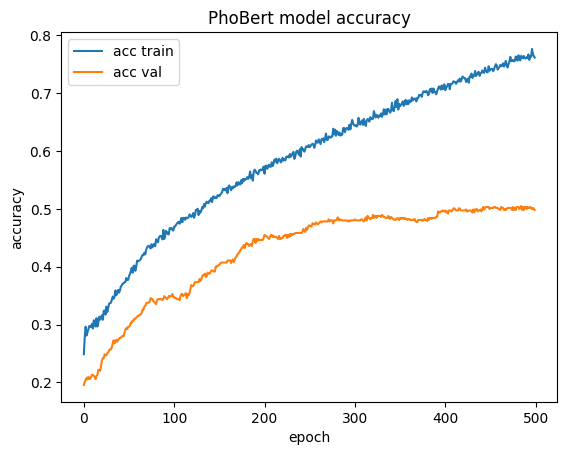

In [16]:
#ACC train and val
import matplotlib.pyplot as plt
plt.plot(echo,acc)
plt.plot(echo,acc_val)
plt.title('PhoBert model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc train', 'acc val'], loc='upper left')
plt.savefig('./result/ModelV1/acc_200e_6Label_base.png',bbox_inches='tight')
plt.show()

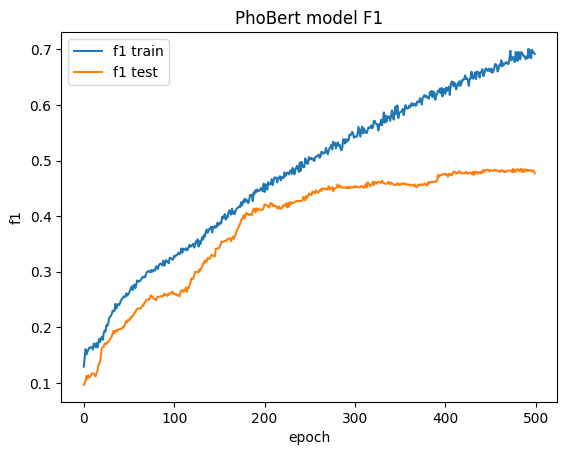

In [17]:
#F1 train and val
import matplotlib.pyplot as plt
plt.plot(echo,f1)
plt.plot(echo,f1_val)
plt.title('PhoBert model F1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1 train', 'f1 test'], loc='upper left')
plt.savefig('./result/ModelV1/f1_200e_6Label_base.png', bbox_inches='tight')
plt.show()

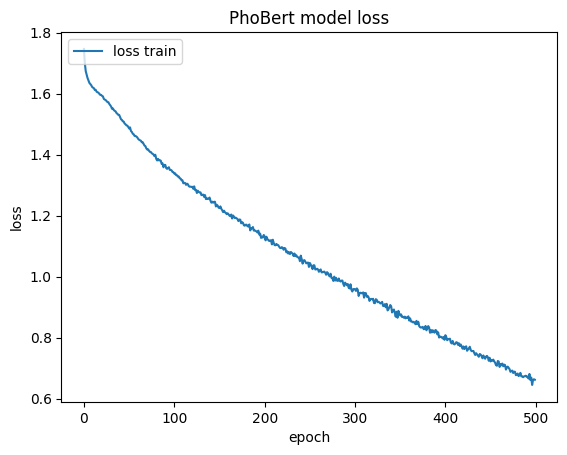

In [18]:
#Loss
import matplotlib.pyplot as plt
plt.plot(echo,av_loss)
# plt.plot(echo,y1)
plt.title('PhoBert model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss train'], loc='upper left')
plt.savefig('./result/ModelV1/loss_200e_6Label_base.png', bbox_inches='tight')
plt.show()

In [ ]:
!zip -r ./model.zip ./Deep/modelbert/5

# ***Test***

In [ ]:
path_config = './model/9/config.json'
path_model = './model/9/pytorch_model.bin'
path_bpe = './PhoBERT_base_transformers/bpe.codes'
path_vocab = './PhoBERT_base_transformers/dict.txt'
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
def get_model(path_model= None, path_config = None, path_bpe = None, path_vocab = None):
  config = RobertaConfig.from_pretrained(
      path_config, from_tf=False, num_labels = 8, output_hidden_states=False
  )
  BERT_SA_NEW = RobertaForSequenceClassification.from_pretrained(
      path_model,
      ignore_mismatched_sizes=True,
      config=config
  )
  # BERT_SA_NEW.cuda()
  BERT_SA_NEW.eval()


  try:
    parser = argparse.ArgumentParser()
    parser.add_argument('--bpe-codes', 
        default=path_bpe,
        required=False,
        type=str,
        help='path to fastBPE BPE'
    )
    args, unknown = parser.parse_known_args()
    bpe = fastBPE(args)
  except:
    bpe = None
    print("load bpe fail")

  try:
    vocab = Dictionary()
    vocab.add_from_file(path_vocab)
  except:
    vocab=None
    print('load vocab fail')
  return BERT_SA_NEW, bpe, vocab

model, bpe, vocab = get_model(path_model, path_config, path_bpe, path_vocab)

In [ ]:
def predict(model, bpe, sense, vocab):
  subwords = '<s> ' + bpe.encode(sense) + ' </s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
  encoded_sent = pad_sequences([encoded_sent], maxlen=195, dtype="long", value=0, truncating="post", padding="post")
  mask = [int(token_id > 0) for token_id in encoded_sent[0]]


  # encoded_sent = torch.tensor(encoded_sent).cuda()
  # mask = torch.tensor(mask).cuda()
  encoded_sent = torch.tensor(encoded_sent)
  mask = torch.tensor(mask)
  encoded_sent = torch.reshape(encoded_sent, (1, 195))
  mask = torch.reshape(mask, (1, 195))

  with torch.no_grad():
    outputs = model(encoded_sent, 
      token_type_ids=None, 
      attention_mask=mask)
    logits = outputs[0]
  return int(torch.argmax(logits))

In [ ]:
sent = 'một lí do trong muôn vàn lí do'
predict(model, bpe, sent, vocab)